## [Kaggle Clone Coding] Toxic Comment Classification Challenge
- [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
- [Tackling Toxic Using Keras](https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras)
  
- Task : 댓글 유형의 독성 확률을 예측
---

### Kaggle API를 통해 코랩에 데이터 다운로드

In [5]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"yoonj98","key":"6ccc197c1ed7c51215ef6212f6edfaba"}'}

In [2]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle/kaggle/'
os.getcwd()

%cd /content/drive/MyDrive/Kaggle/kaggle/

/content/drive/MyDrive/Kaggle/kaggle


In [7]:
# 다운받고자하는 대회의 data 탭에서 api 주소 가져오기
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 91% 24.0M/26.3M [00:00<00:00, 52.5MB/s]
100% 26.3M/26.3M [00:00<00:00, 53.4MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 45.8MB/s]
 94% 22.0M/23.4M [00:00<00:00, 70.0MB/s]
100% 23.4M/23.4M [00:00<00:00, 67.3MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 46.2MB/s]


In [8]:
# 데이터 확인
!ls

'kaggle (1).json'   sample_submission.csv.zip   test_labels.csv.zip
 kaggle.json	    test.csv.zip	        train.csv.zip


In [11]:
# 압축해제
!unzip test.csv.zip	        
!unzip train.csv.zip	        
!unzip test_labels.csv.zip	        
!unzip sample_submission.csv.zip	        

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [10]:
# 데이터 확인
!ls

'kaggle (1).json'   sample_submission.csv.zip   test_labels.csv.zip
 kaggle.json	    test.csv.zip	        train.csv.zip


---
### Code

In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# 결측치 X

train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [5]:
# train set으로부터 X, Y 분리

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

#### preprocessing
* Tokenization : 우리는 문장을 독특한 단어로 나눌 필요가 있습니다. 예를 들어, "나는 고양이를 사랑하고 개를 사랑한다"는 ["I","love","cats","and","dogs"]가 될 것이다.  
* Indexing :  단어를 사전과 같은 구조로 놓고 각각 인덱스를 부여합니다. 예 : {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}  
* Index Representation : 우리는 주석의 단어 순서를 색인 형태로 표현할 수 있고, 이 색인 사슬을 LSTM에 공급할 수 있다. 예: [1,2,3,4,2,5]

In [6]:
max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

다만, 어떤 댓글은 너무 긴 반면 어떤 댓글은 한 단어로만 이루어진 경우 데이터는 다음과 같을 것이다. 

댓글 #1: [8,9,3,7,3,3,3,6,6,6,2,3,4,9]  
댓글 #2: [1,2]

또한 일정한 길이(특징 수)의 데이터를 제공해야 하므로, 패딩을 통해 짧은 댓글의 부족한 부분을 0으로 채워서 다른 문장처럼 만들 수 있다.   
또한, 긴 댓글도 짧은 댓글과 같은 길이(최대 길이)로 잘라야 하므로, 최대 길이를 200으로 설정했다.

In [7]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [8]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

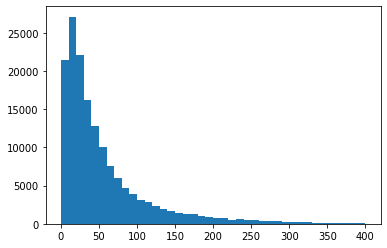

In [9]:
plt.hist(totalNumWords,bins = np.arange(0,410,10)) #[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

#### Build Model

In [10]:
embed_size = 128
inp = Input(shape=(maxlen, )) # maxlen=200

In [11]:
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [12]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [13]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 55s 11ms/step - loss: 0.0689 - accuracy: 0.9736 - val_loss: 0.0502 - val_accuracy: 0.9939
Epoch 2/2
4488/4488 [==============================] - 50s 11ms/step - loss: 0.0452 - accuracy: 0.9910 - val_loss: 0.0467 - val_accuracy: 0.9937


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [15]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape

(1, 200, 60)